In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, brier_score_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, InputLayer, Dropout

# utilities
import joblib


In [4]:
#Load dataset 
df = pd.read_csv("Heart_disease_cleveland_new.csv")  
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,0,145,233,1,2,150,0,2.3,2,0,2,0
1,67,1,3,160,286,0,2,108,1,1.5,1,3,1,1
2,67,1,3,120,229,0,2,129,1,2.6,1,2,3,1
3,37,1,2,130,250,0,0,187,0,3.5,2,0,1,0
4,41,0,1,130,204,0,2,172,0,1.4,0,0,1,0


In [5]:
df.columns


Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [6]:

print(df.shape)
print(df.isnull().sum())
df.describe().T


(303, 14)
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
age,303.0,54.438944,9.038662,29.0,48.0,56.0,61.0,77.0
sex,303.0,0.679868,0.467299,0.0,0.0,1.0,1.0,1.0
cp,303.0,2.158416,0.960126,0.0,2.0,2.0,3.0,3.0
trestbps,303.0,131.689769,17.599748,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.693069,51.776918,126.0,211.0,241.0,275.0,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.990099,0.994971,0.0,0.0,1.0,2.0,2.0
thalach,303.0,149.607261,22.875003,71.0,133.5,153.0,166.0,202.0
exang,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [7]:
# Impute numeric missing with median
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols] = df[num_cols].fillna(df[num_cols].median())


In [8]:
# Features and labels
X = df.drop(columns=['target'])
y = df['target']

cat_cols = ['cp','restecg','slope','thal','ca']  
cat_cols = [c for c in cat_cols if c in X.columns]
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

X.shape, y.shape


((303, 20), (303,))

In [9]:
# Standardize features 
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
joblib.dump(scaler, "scaler.joblib")


['scaler.joblib']

In [10]:
# Metrics utilities 
def calc_from_confusion(cm):
    TP, FN = cm[0][0], cm[0][1]
    FP, TN = cm[1][0], cm[1][1]
    eps = 1e-10
    TPR = TP / (TP + FN + eps)
    TNR = TN / (TN + FP + eps)
    FPR = FP / (TN + FP + eps)
    FNR = FN / (TP + FN + eps)
    Precision = TP / (TP + FP + eps)
    F1 = 2 * TP / (2 * TP + FP + FN + eps)
    Accuracy = (TP + TN) / (TP + TN + FP + FN + eps)
    Error_rate = (FP + FN) / (TP + TN + FP + FN + eps)
    BACC = (TPR + TNR) / 2
    TSS = TPR - FPR
    HSS = 2 * (TP*TN - FP*FN) / (((TP+FN)*(FN+TN) + (TP+FP)*(FP+TN)) + eps)
    return {
        'TP':TP,'TN':TN,'FP':FP,'FN':FN,
        'TPR':TPR,'TNR':TNR,'FPR':FPR,'FNR':FNR,
        'Precision':Precision,'F1':F1,'Accuracy':Accuracy,'Error_rate':Error_rate,
        'BACC':BACC,'TSS':TSS,'HSS':HSS
    }

def brier_skill_score(brier, brier_ref):
    eps=1e-10
    return 1.0 - (brier / (brier_ref + eps))


In [11]:
# Stratified K-Fold setup
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# placeholders for per-fold metrics
rf_results = []
svm_results = []
gru_results = []


In [12]:
# GridSearch for RF and SVM
rf = RandomForestClassifier(random_state=42)
rf_params = {'n_estimators':[50,100,150], 'min_samples_split':[2,4,6]}

svm = SVC(probability=True)
svm_params = {'C':[0.1,1,3], 'kernel':['linear']}

grid_rf = GridSearchCV(rf, rf_params, cv=5, n_jobs=-1)
grid_rf.fit(X_scaled, y)
print("Best RF params:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

grid_svm = GridSearchCV(svm, svm_params, cv=5, n_jobs=-1)
grid_svm.fit(X_scaled, y)
print("Best SVM params:", grid_svm.best_params_)
best_svm = grid_svm.best_estimator_


Best RF params: {'min_samples_split': 6, 'n_estimators': 100}
Best SVM params: {'C': 0.1, 'kernel': 'linear'}


In [13]:
joblib.dump(best_rf, "best_rf.joblib")
joblib.dump(best_svm, "best_svm.joblib")


['best_svm.joblib']

In [14]:
#  CV loop
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples

# reference brier for BSS: probability climatology (mean of y)
brier_ref = brier_score_loss(y, np.full_like(y, y.mean(), dtype=float))

for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled, y), start=1):
    X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Random Forest
    rf_m = RandomForestClassifier(**grid_rf.best_params_, random_state=42)
    rf_m.fit(X_train, y_train)
    rf_prob = rf_m.predict_proba(X_test)[:,1]
    rf_pred = (rf_prob > 0.5).astype(int)
    cm_rf = confusion_matrix(y_test, rf_pred, labels=[1,0])
    rf_metrics = calc_from_confusion(cm_rf)
    rf_brier = brier_score_loss(y_test, rf_prob)
    rf_auc = roc_auc_score(y_test, rf_prob)
    rf_metrics.update({'Brier':rf_brier, 'AUC':rf_auc, 'BSS': brier_skill_score(rf_brier, brier_ref)})
    rf_results.append(rf_metrics)
    
    # SVM
    svm_m = SVC(**grid_svm.best_params_, probability=True)
    svm_m.fit(X_train, y_train)
    svm_prob = svm_m.predict_proba(X_test)[:,1]
    svm_pred = (svm_prob > 0.5).astype(int)
    cm_svm = confusion_matrix(y_test, svm_pred, labels=[1,0])
    svm_metrics = calc_from_confusion(cm_svm)
    svm_brier = brier_score_loss(y_test, svm_prob)
    svm_auc = roc_auc_score(y_test, svm_prob)
    svm_metrics.update({'Brier':svm_brier, 'AUC':svm_auc, 'BSS': brier_skill_score(svm_brier, brier_ref)})
    svm_results.append(svm_metrics)
    
    # GRU model
  
    tf.keras.backend.clear_session()
    input_shape = (X_train.shape[1], 1)
    gru_model = Sequential()
    gru_model.add(InputLayer(input_shape=input_shape))
    gru_model.add(GRU(32, activation='tanh', return_sequences=False))
    gru_model.add(Dropout(0.2))
    gru_model.add(Dense(1, activation='sigmoid'))
    gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # reshape to (samples, timesteps, channels) -> here we use (n_features, 1) timesteps
    Xtr = X_train.to_numpy().reshape(len(X_train), X_train.shape[1], 1)
    Xte = X_test.to_numpy().reshape(len(X_test), X_test.shape[1], 1)
    
    gru_model.fit(Xtr, y_train.to_numpy(), epochs=30, batch_size=16, validation_data=(Xte, y_test.to_numpy()), verbose=0)
    gru_prob = gru_model.predict(Xte).ravel()
    gru_pred = (gru_prob > 0.5).astype(int)
    cm_gru = confusion_matrix(y_test, gru_pred, labels=[1,0])
    gru_metrics = calc_from_confusion(cm_gru)
    gru_brier = brier_score_loss(y_test, gru_prob)
    gru_auc = roc_auc_score(y_test, gru_prob)
    gru_metrics.update({'Brier':gru_brier, 'AUC':gru_auc, 'BSS': brier_skill_score(gru_brier, brier_ref)})
    gru_results.append(gru_metrics)
    
    print(f"Fold {fold} done.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Fold 1 done.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Fold 2 done.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Fold 3 done.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Fold 4 done.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Fold 5 done.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Fold 6 done.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Fold 7 done.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Fold 8 done.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Fold 9 done.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Fold 10 done.


In [15]:
#  Convert to DataFrame and average metrics
def results_to_df(results_list):
    return pd.DataFrame(results_list).T

rf_df = pd.DataFrame(rf_results)
svm_df = pd.DataFrame(svm_results)
gru_df = pd.DataFrame(gru_results)

# Show per-fold metrics (rounded)
print("Random Forest per-fold (first 5 cols):")
display(rf_df.round(3))
print("Averages:")
display(rf_df.mean().round(3))

print("SVM per-fold:")
display(svm_df.round(3))
print("Averages:")
display(svm_df.mean().round(3))

print("GRU per-fold:")
display(gru_df.round(3))
print("Averages:")
display(gru_df.mean().round(3))


Random Forest per-fold (first 5 cols):


,TP,TN,FP,FN,TPR,TNR,FPR,FNR,Precision,F1,Accuracy,Error_rate,BACC,TSS,HSS,Brier,AUC,BSS
0,12,14,3,2,0.857,0.824,0.176,0.143,0.800,0.828,0.839,0.161,0.840,0.681,0.676,0.134,0.899,0.460
1,11,17,0,3,0.786,1.000,0.000,0.214,1.000,0.880,0.903,0.097,0.893,0.786,0.801,0.099,0.954,0.599
2,12,12,5,2,0.857,0.706,0.294,0.143,0.706,0.774,0.774,0.226,0.782,0.563,0.553,0.154,0.878,0.381
3,9,13,4,4,0.692,0.765,0.235,0.308,0.692,0.692,0.733,0.267,0.729,0.457,0.457,0.149,0.878,0.400
4,13,11,5,1,0.929,0.687,0.312,0.071,0.722,0.812,0.800,0.200,0.808,0.616,0.605,0.143,0.906,0.426
5,7,14,2,7,0.500,0.875,0.125,0.500,0.778,0.609,0.700,0.300,0.687,0.375,0.384,0.162,0.853,0.348
6,11,15,1,3,0.786,0.937,0.062,0.214,0.917,0.846,0.867,0.133,0.862,0.723,0.730,0.100,0.960,0.598
7,9,12,4,5,0.643,0.750,0.250,0.357,0.692,0.667,0.700,0.300,0.696,0.393,0.395,0.160,0.857,0.355
8,11,16,0,3,0.786,1.000,0.000,0.214,1.000,0.880,0.900,0.100,0.893,0.786,0.796,0.103,0.951,0.583
9,10,14,2,4,0.714,0.875,0.125,0.286,0.833,0.769,0.800,0.200,0.795,0.589,0.595,0.145,0.897,0.417


Averages:


TP            10.500
TN            13.800
FP             2.600
FN             3.400
TPR            0.755
TNR            0.842
FPR            0.158
FNR            0.245
Precision      0.814
F1             0.776
Accuracy       0.802
Error_rate     0.198
BACC           0.798
TSS            0.597
HSS            0.599
Brier          0.135
AUC            0.903
BSS            0.457
dtype: float64

SVM per-fold:


,TP,TN,FP,FN,TPR,TNR,FPR,FNR,Precision,F1,Accuracy,Error_rate,BACC,TSS,HSS,Brier,AUC,BSS
0,10,15,2,4,0.714,0.882,0.118,0.286,0.833,0.769,0.806,0.194,0.798,0.597,0.604,0.125,0.903,0.496
1,12,16,1,2,0.857,0.941,0.059,0.143,0.923,0.889,0.903,0.097,0.899,0.798,0.803,0.082,0.962,0.669
2,11,14,3,3,0.786,0.824,0.176,0.214,0.786,0.786,0.806,0.194,0.805,0.609,0.609,0.134,0.878,0.462
3,11,14,3,2,0.846,0.824,0.176,0.154,0.786,0.815,0.833,0.167,0.835,0.670,0.664,0.124,0.914,0.500
4,12,11,5,2,0.857,0.687,0.312,0.143,0.706,0.774,0.767,0.233,0.772,0.545,0.537,0.120,0.920,0.517
5,9,13,3,5,0.643,0.812,0.187,0.357,0.750,0.692,0.733,0.267,0.728,0.455,0.459,0.152,0.871,0.386
6,10,16,0,4,0.714,1.000,0.000,0.286,1.000,0.833,0.867,0.133,0.857,0.714,0.727,0.098,0.955,0.606
7,9,12,4,5,0.643,0.750,0.250,0.357,0.692,0.667,0.700,0.300,0.696,0.393,0.395,0.156,0.871,0.370
8,12,14,2,2,0.857,0.875,0.125,0.143,0.857,0.857,0.867,0.133,0.866,0.732,0.732,0.087,0.924,0.649
9,10,14,2,4,0.714,0.875,0.125,0.286,0.833,0.769,0.800,0.200,0.795,0.589,0.595,0.150,0.866,0.394


Averages:


TP            10.600
TN            13.900
FP             2.500
FN             3.300
TPR            0.763
TNR            0.847
FPR            0.153
FNR            0.237
Precision      0.817
F1             0.785
Accuracy       0.808
Error_rate     0.192
BACC           0.805
TSS            0.610
HSS            0.613
Brier          0.123
AUC            0.906
BSS            0.505
dtype: float64

GRU per-fold:


,TP,TN,FP,FN,TPR,TNR,FPR,FNR,Precision,F1,Accuracy,Error_rate,BACC,TSS,HSS,Brier,AUC,BSS
0,12,15,2,2,0.857,0.882,0.118,0.143,0.857,0.857,0.871,0.129,0.870,0.739,0.739,0.110,0.924,0.558
1,13,16,1,1,0.929,0.941,0.059,0.071,0.929,0.929,0.935,0.065,0.935,0.870,0.870,0.090,0.937,0.636
2,10,12,5,4,0.714,0.706,0.294,0.286,0.667,0.690,0.710,0.290,0.710,0.420,0.418,0.170,0.857,0.314
3,10,16,1,3,0.769,0.941,0.059,0.231,0.909,0.833,0.867,0.133,0.855,0.710,0.724,0.116,0.928,0.534
4,11,15,1,3,0.786,0.937,0.062,0.214,0.917,0.846,0.867,0.133,0.862,0.723,0.730,0.104,0.929,0.583
5,9,14,2,5,0.643,0.875,0.125,0.357,0.818,0.720,0.767,0.233,0.759,0.518,0.525,0.165,0.848,0.335
6,10,13,3,4,0.714,0.812,0.187,0.286,0.769,0.741,0.767,0.233,0.763,0.527,0.529,0.114,0.906,0.543
7,10,11,5,4,0.714,0.687,0.312,0.286,0.667,0.690,0.700,0.300,0.701,0.402,0.400,0.172,0.835,0.308
8,10,14,2,4,0.714,0.875,0.125,0.286,0.833,0.769,0.800,0.200,0.795,0.589,0.595,0.125,0.897,0.496
9,8,14,2,6,0.571,0.875,0.125,0.429,0.800,0.667,0.733,0.267,0.723,0.446,0.455,0.157,0.848,0.366


Averages:


TP            10.300
TN            14.000
FP             2.400
FN             3.600
TPR            0.741
TNR            0.853
FPR            0.147
FNR            0.259
Precision      0.817
F1             0.774
Accuracy       0.802
Error_rate     0.198
BACC           0.797
TSS            0.595
HSS            0.598
Brier          0.132
AUC            0.891
BSS            0.467
dtype: float64

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


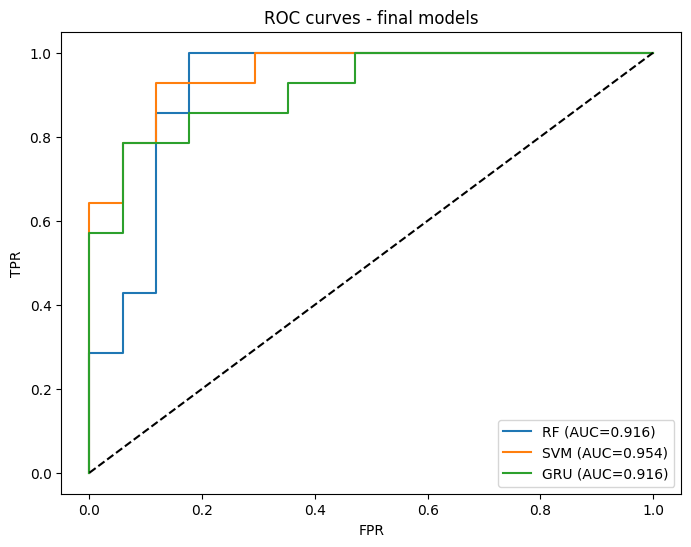

In [16]:
# Train final models on full dataset, then plot ROC on held-out test split
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_scaled, y, test_size=0.1, stratify=y, random_state=42)

best_rf.fit(X_train_full, y_train_full)
best_svm.fit(X_train_full, y_train_full)
# GRU
tf.keras.backend.clear_session()
gru_final = Sequential()
gru_final.add(InputLayer(input_shape=(X_train_full.shape[1],1)))
gru_final.add(GRU(32))
gru_final.add(Dropout(0.2))
gru_final.add(Dense(1, activation='sigmoid'))
gru_final.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
gru_final.fit(X_train_full.to_numpy().reshape(len(X_train_full), X_train_full.shape[1],1),
              y_train_full.to_numpy(), epochs=40, batch_size=16, verbose=0)

# get probs
rf_p = best_rf.predict_proba(X_test_full)[:,1]
svm_p = best_svm.predict_proba(X_test_full)[:,1]
gru_p = gru_final.predict(X_test_full.to_numpy().reshape(len(X_test_full), X_test_full.shape[1],1)).ravel()

plt.figure(figsize=(8,6))
for name, probs in [('RF', rf_p), ('SVM', svm_p), ('GRU', gru_p)]:
    fpr, tpr, _ = roc_curve(y_test_full, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC curves - final models'); plt.legend()
plt.show()
